In [1]:
import os
import time
import random
import string
import logging
from datetime import timedelta

import numpy as np
import pandas as pd
import cv2
import base64
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set up logging
logging.basicConfig(filename='training_baseline.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")
print(f"Using device: {device}")

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

Using device: cpu


In [3]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from utils import tif_to_ndarray, decode_image

# Load the data
df = pd.read_csv('data/training.csv')
logging.info("Loaded training data.")

# Print dataframe info
print("Dataframe Info:")
print(df.info())

print("\nDataframe Columns:")
print(df.columns)

print("\nFirst few rows of the dataframe:")
print(df.head())

# Function to load and encode images
def load_and_encode_image(file_path):
    img_array = tif_to_ndarray(file_path)
    return img_array

# Check if 'image_id' column exists in the dataframe before applying the function
if 'image_id' in df.columns:
    df['image_array'] = df['image_id'].apply(lambda x: load_and_encode_image(f'data/training/{x}.tif'))
    logging.info("Added image arrays to dataframe.")
else:
    logging.error("Column 'image_id' not found in the dataframe.")

# Rename 'is_homogenous' to 'label' for consistency with the rest of the code
df = df.rename(columns={'is_homogenous': 'label'})

# Check if 'label' column exists
if 'label' not in df.columns:
    logging.error("Column 'label' not found in the dataframe.")
    print("Available columns:", df.columns)
    raise KeyError("'label' column is missing from the dataframe")

# Split the data into training and validation sets with stratification to maintain class balance
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
logging.info(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

print("\nUpdated dataframe columns:")
print(df.columns)

print("\nFirst few rows of the updated dataframe:")
print(df.head())

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   image_id       139 non-null    int64
 1   is_homogenous  139 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB
None

Dataframe Columns:
Index(['image_id ', 'is_homogenous'], dtype='object')

First few rows of the dataframe:
   image_id   is_homogenous
0        279              0
1        277              0
2        275              0
3        273              0
4        271              0

Updated dataframe columns:
Index(['image_id ', 'label'], dtype='object')

First few rows of the updated dataframe:
   image_id   label
0        279      0
1        277      0
2        275      0
3        273      0
4        271      0


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   image_id       139 non-null    int64
 1   is_homogenous  139 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB
None

Dataframe Columns:
Index(['image_id ', 'is_homogenous'], dtype='object')

First few rows of the dataframe:
   image_id   is_homogenous
0        279              0
1        277              0
2        275              0
3        273              0
4        271              0

Updated dataframe columns:
Index(['image_id ', 'label', 'image_array'], dtype='object')

First few rows of the updated dataframe:
   image_id   label                                        image_array
0        279      0  [[330, 308, 313, 335, 335, 309, 312, 308, 297,...
1        277      0  [[318, 299, 317, 305, 262, 299, 301, 312, 312,...
2        275      0  [[327, 293, 324, 303, 324, 2

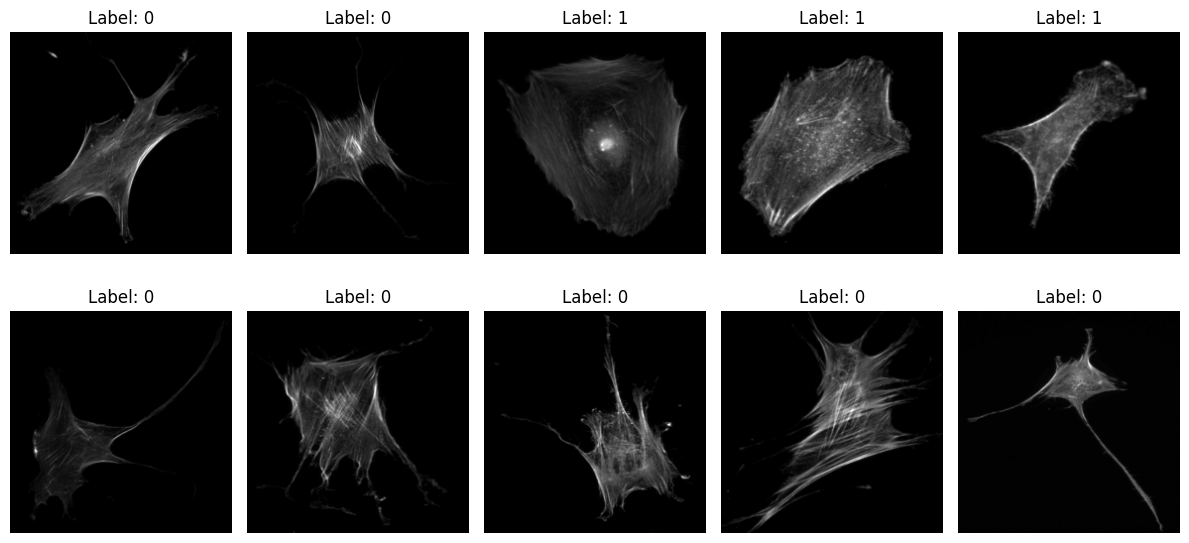

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from utils import tif_to_ndarray
import matplotlib.pyplot as plt

class CellDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_array = self.dataframe.iloc[idx]['image_array']
        label = self.dataframe.iloc[idx]['label']

        # Convert uint16 to uint8
        img_array = (img_array / 256).astype(np.uint8)

        if self.transform:
            img_array = self.transform(img_array)

        return img_array, label

# Load and preprocess your data
df = pd.read_csv('data/training.csv')
print("Dataframe Info:")
print(df.info())

print("\nDataframe Columns:")
print(df.columns)

print("\nFirst few rows of the dataframe:")
print(df.head())

# Function to load and encode images
def load_and_encode_image(file_path):
    img_array = tif_to_ndarray(file_path)
    return img_array

# Add 'image_array' column to the dataframe
df['image_array'] = df['image_id '].apply(lambda x: load_and_encode_image(f'data/training/{x:03d}.tif'))

# Rename 'is_homogenous' to 'label'
df = df.rename(columns={'is_homogenous': 'label'})

print("\nUpdated dataframe columns:")
print(df.columns)

print("\nFirst few rows of the updated dataframe:")
print(df.head())

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Define the transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Create dataset instances
train_dataset = CellDataset(train_df, transform=transform)
val_dataset = CellDataset(val_df, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Log and Plot Cell Dataset
print("Cell Dataset created.")

# Plot the first 10 images from the training dataset
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img_array = train_dataset[i][0].squeeze().numpy()  # Get the image array and convert to numpy
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Label: {train_dataset[i][1]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def get_resnet18(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = get_resnet18(num_classes=2)
model = model.to(device)
logging.info("Initialized ResNet18 model.")

# Calculate class weights
class_counts = train_df['label'].value_counts().sort_index()
n_classes = len(class_counts)
class_weights = [0.0] * n_classes
total_samples = len(train_df)

for i in range(n_classes):
    class_weights = [float(total_samples / (n_classes * class_counts[i])) for i in range(n_classes)]

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
logging.info(f"Class weights: {class_weights}")
print(f"Class weights: {class_weights}")

Class weights: [0.6032608695652174, 2.9210526315789473]


In [6]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

logging.info("Defined loss function, optimizer, and scheduler.")

In [7]:
def calculate_custom_score(y_true, y_pred):
    n0 = sum(1 for label in y_true if label == 0)
    n1 = sum(1 for label in y_true if label == 1)
    a0 = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)
    a1 = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    return (a0 * a1) / (n0 * n1) if (n0 * n1) != 0 else 0

In [8]:
import random
import os

# Generate a random name
def generate_random_name():
    adjectives = ['swift', 'bold', 'clever', 'dapper', 'eager', 'fierce', 'gentle', 'happy', 'jolly', 'kind']
    nouns = ['panda', 'eagle', 'tiger', 'dolphin', 'koala', 'falcon', 'wolf', 'owl', 'fox', 'bear']
    return f"{random.choice(adjectives)}_{random.choice(nouns)}_{random.randint(1000, 9999)}"

# Generate a random name for this run
run_name = generate_random_name()
print(f"Run name: {run_name}")

# Create a directory for this run
run_dir = os.path.join('runs', run_name)
os.makedirs(run_dir, exist_ok=True)

# Set up logging to write to a file in the run directory
log_file = os.path.join(run_dir, f'{run_name}.log')
logging.basicConfig(filename=log_file, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Run name: {run_name}")
logging.info(f"Run directory: {run_dir}")

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5):
    train_losses, train_accuracies, train_scores = [], [], []
    val_losses, val_accuracies, val_scores = [], [], []
    
    best_val_score = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_score = calculate_custom_score(all_train_labels, all_train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_scores.append(train_score)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_score = calculate_custom_score(all_val_labels, all_val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_scores.append(val_score)

        # Learning rate scheduling
        scheduler.step(val_score)

        # Early stopping
        if val_score > best_val_score:
            best_val_score = val_score
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), os.path.join(run_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

        # Logging
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        logging.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Score: {train_score:.4f}")
        logging.info(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Score: {val_score:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Score: {train_score:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Score: {val_score:.4f}")
        print("-" * 50)
    
    return train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores


Run name: bold_panda_5506


In [9]:
num_epochs = 20
logging.info("Starting training...")
train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs
)
logging.info("Training completed.")

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=['Heterogeneous', 'Homogeneous'])
    return cm, class_report, all_labels, all_preds

# Evaluate the model
cm, class_report, all_labels, all_preds = evaluate_model(model, val_loader)

# Calculate Final Custom Score
final_score = calculate_custom_score(all_labels, all_preds)
logging.info(f"Final Custom Score: {final_score:.4f}")

# Save the model
model_path = os.path.join(run_dir, f"{run_name}_model.pth")
torch.save(model.state_dict(), model_path)
logging.info(f"Model saved as {model_path}")

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Heterogeneous', 'Homogeneous'], 
            yticklabels=['Heterogeneous', 'Homogeneous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
plt.close()

# Save Classification Report
with open(os.path.join(run_dir, 'classification_report.txt'), 'w') as f:
    f.write("Classification Report:\n")
    f.write(class_report)
    f.write(f"\nFinal Custom Score: {final_score:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_scores, label='Train')
plt.plot(val_scores, label='Validation')
plt.title('Custom Score')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'training_curves.png'))
plt.close()

# Save metrics as CSV
metrics_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'train_score': train_scores,
    'val_score': val_scores
})
metrics_df.to_csv(os.path.join(run_dir, 'metrics.csv'), index=False)

print(f"All outputs saved in the directory: {run_dir}")

Epoch 1/20: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


Epoch 1/20:
Train Loss: 0.7696, Train Acc: 0.4685, Train Score: 0.3175
Val Loss: 0.8169, Val Acc: 0.8214, Val Score: 0.0000
--------------------------------------------------


Epoch 2/20: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch 2/20:
Train Loss: 0.3677, Train Acc: 0.8468, Train Score: 0.7140
Val Loss: 0.6794, Val Acc: 0.8214, Val Score: 0.0000
--------------------------------------------------


Epoch 3/20: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Epoch 3/20:
Train Loss: 0.1658, Train Acc: 0.8739, Train Score: 0.8478
Val Loss: 1.0288, Val Acc: 0.8214, Val Score: 0.0000
--------------------------------------------------


Epoch 4/20: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch 4/20:
Train Loss: 0.2072, Train Acc: 0.9640, Train Score: 0.8753
Val Loss: 3.2560, Val Acc: 0.8214, Val Score: 0.0000
--------------------------------------------------


Epoch 5/20: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Early stopping triggered after epoch 5


/Users/phongsakon/ai_comp_2024/DM-i-AI-2024/cell-classification-final/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phongsakon/ai_comp_2024/DM-i-AI-2024/cell-classification-final/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/phongsakon/ai_comp_2024/DM-i-AI-2024/cell-classification-final/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

All outputs saved in the directory: runs/bold_panda_5506
